In [45]:
import nltk                                # Python library for NLP
import matplotlib.pyplot as plt            # library for visualization
import pandas as pd
import numpy as np
import re                                  # library for regular expression operations
import string                              # for string operations
from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# Read data set

In [3]:
train_data = pd.read_csv('/kaggle/input/shai-training-2023-a-level-2/Train.csv')
val_data = pd.read_csv('/kaggle/input/shai-training-2023-a-level-2/Valid.csv')
test_data = pd.read_csv('/kaggle/input/shai-training-2023-a-level-2/Test.csv')

In [4]:
print('train_data shape: ', train_data.shape)
print('val_data shape: ', val_data.shape)
print('test_data shape: ', test_data.shape)

train_data shape:  (40000, 2)
val_data shape:  (5000, 2)
test_data shape:  (5000, 3)


In [5]:
train_data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [6]:
group = train_data.groupby('label')['label'].count()

print('Number of Positive review : ',group[1])
print('Number of Negative review : ', group[0])

Number of Positive review :  19981
Number of Negative review :  20019


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [8]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


**there is no missing values**

<AxesSubplot: xlabel='label', ylabel='count'>

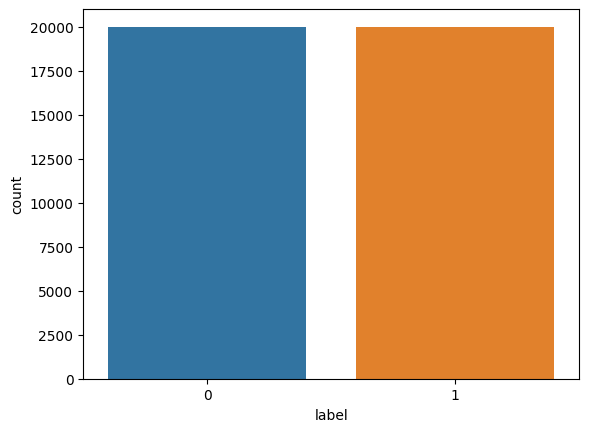

In [10]:
import seaborn as sns
sns.countplot(x='label', data=train_data)

# Data Preprocessing

In [11]:
train_text = train_data['text']
train_labels = train_data['label']

### Remove stop words and punctuations

In [12]:
STOPWORDS = stopwords.words('english')
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

train_text = train_text.apply(lambda text: cleaning_stopwords(text))
train_text.head()

0    I grew (b. 1965) watching loving Thunderbirds....
1    When I put movie DVD player, sat coke chips, I...
2    Why people know particular time past like feel...
3    Even though I great interest Biblical movies, ...
4    Im die hard Dads Army fan nothing ever change ...
Name: text, dtype: object

### Cleaning and removing punctuations

In [13]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

train_text =  train_text.apply(lambda x: cleaning_punctuations(x))
train_text.tail()

39995    Western Union something forgotten classic west...
39996    This movie incredible piece work It explores e...
39997    My wife I watched movie plan visit Sicily Stro...
39998    When I first watched Flatliners I amazed It ne...
39999    Why would film good gross estimated 95000000 N...
Name: text, dtype: object

### Cleaning and removing repeating characters

In [14]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)

train_text = train_text.apply(lambda x: cleaning_repeating_char(x))
train_text.tail()

39995    Western Union something forgotten classic west...
39996    This movie incredible piece work It explores e...
39997    My wife I watched movie plan visit Sicily Stro...
39998    When I first watched Flatliners I amazed It ne...
39999    Why would film good gross estimated 95000000 N...
Name: text, dtype: object

### Remove hyperlinks, Twitter marks and styles

In [15]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

train_text = train_text.apply(lambda x: cleaning_URLs(x))
train_text.tail()

39995    Western Union something forgotten classic west...
39996    This movie incredible piece work It explores e...
39997    My wife I watched movie plan visit Sicily Stro...
39998    When I first watched Flatliners I amazed It ne...
39999    Why would film good gross estimated 95000000 N...
Name: text, dtype: object

### Cleaning and removing numeric numbers

In [16]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

train_text = train_text.apply(lambda x: cleaning_numbers(x))
train_text.tail()

39995    Western Union something forgotten classic west...
39996    This movie incredible piece work It explores e...
39997    My wife I watched movie plan visit Sicily Stro...
39998    When I first watched Flatliners I amazed It ne...
39999    Why would film good gross estimated  NO award ...
Name: text, dtype: object

### Remove HTML tags from text

In [ ]:
train_text[0]

In [18]:
import re
regex = re.compile(r'<[^>]+>')

def remove_html(string):
    return regex.sub('', string)

for row in train_text:
    row=remove_html(row)

In [21]:
train_text[0]

'I grew b watching loving Thunderbirds All mates school watched We played Thunderbirds school lunch school We wanted Virgil Scott No one wanted Alan Counting  became art form I took children see movie hoping would get glimpse I loved child How bitterly disappointing The high point snappy theme tune Not could compare original score Thunderbirds Thankfully early Saturday mornings one television channel still plays reruns series Gerry Anderson wife created Jonatha Frakes hand directors chair version completely hopeless A waste film Utter rubbish A CGI remake may acceptable replacing marionettes Homo sapiens subsp sapiens huge error judgment'

### Tokenize the string

In [22]:
# instantiate tokenizer class
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)

In [23]:
train_text = train_text.apply(tokenizer.tokenize)
train_text.head()

0    [i, grew, b, watching, loving, thunderbirds, a...
1    [when, i, put, movie, dvd, player, sat, coke, ...
2    [why, people, know, particular, time, past, li...
3    [even, though, i, great, interest, biblical, m...
4    [im, die, hard, dads, army, fan, nothing, ever...
Name: text, dtype: object

### Stemming

In [24]:
# Instantiate stemming class
stemmer = PorterStemmer()

In [25]:
def stemming_on_text(data):
    text = [stemmer.stem(word) for word in data]
    return data

train_text = train_text.apply(lambda x: stemming_on_text(x))
train_text.head()

0    [i, grew, b, watching, loving, thunderbirds, a...
1    [when, i, put, movie, dvd, player, sat, coke, ...
2    [why, people, know, particular, time, past, li...
3    [even, though, i, great, interest, biblical, m...
4    [im, die, hard, dads, army, fan, nothing, ever...
Name: text, dtype: object

### Applying lemmatizer

In [26]:
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corp

In [27]:
lm = WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

train_text = train_text.apply(lambda x: lemmatizer_on_text(x))
train_text.head()

0    [i, grew, b, watching, loving, thunderbirds, a...
1    [when, i, put, movie, dvd, player, sat, coke, ...
2    [why, people, know, particular, time, past, li...
3    [even, though, i, great, interest, biblical, m...
4    [im, die, hard, dads, army, fan, nothing, ever...
Name: text, dtype: object

# Build model

In [41]:
val_text = val_data['text']
val_labels = val_data['label']

### TF-IDF Vectorizer

In [30]:
train_text = [str (item) for item in train_text]
val_text = [str (item) for item in val_text]

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(train_text)

print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


In [33]:
final_train_text = vectoriser.transform(train_text)
final_val_text  = vectoriser.transform(val_text)

**model_Evaluate method**

In [46]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(final_val_text)
    # Print the evaluation metrics for the dataset.
    print(classification_report(val_labels, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(val_labels, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**plot_roc_curve**

In [47]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()

## Model-1: BernoulliNB

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2486
           1       0.91      0.81      0.86      2514

    accuracy                           0.86      5000
   macro avg       0.87      0.86      0.86      5000
weighted avg       0.87      0.86      0.86      5000



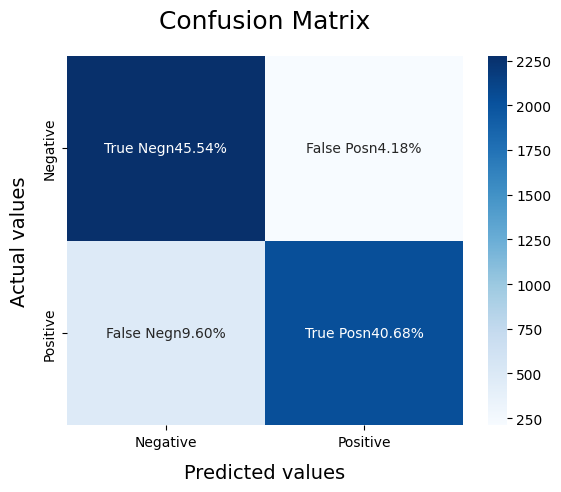

In [48]:
from sklearn.naive_bayes import BernoulliNB

BNBmodel = BernoulliNB()
BNBmodel.fit(final_train_text, train_labels)

model_Evaluate(BNBmodel)

y_pred1 = BNBmodel.predict(final_val_text)

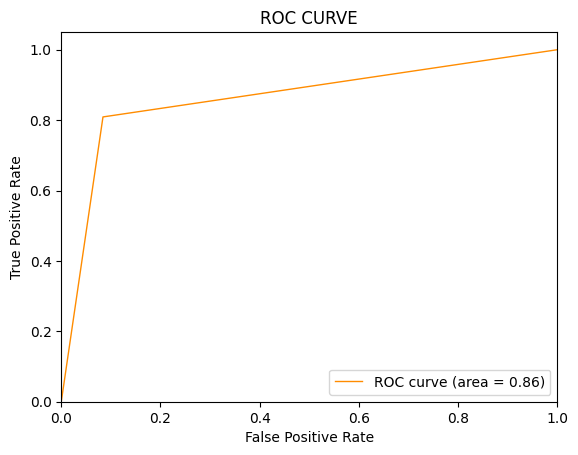

In [49]:
plot_roc_curve(val_labels, y_pred1)

## Model-2: LinearSVC

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2486
           1       0.90      0.88      0.89      2514

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



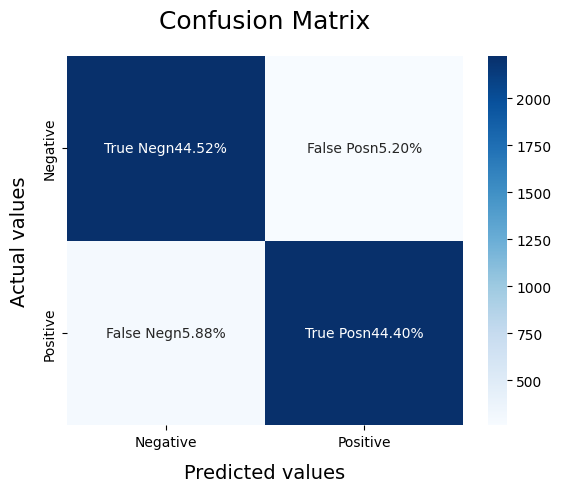

In [51]:
SVCmodel = LinearSVC()
SVCmodel.fit(final_train_text, train_labels)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(final_val_text)

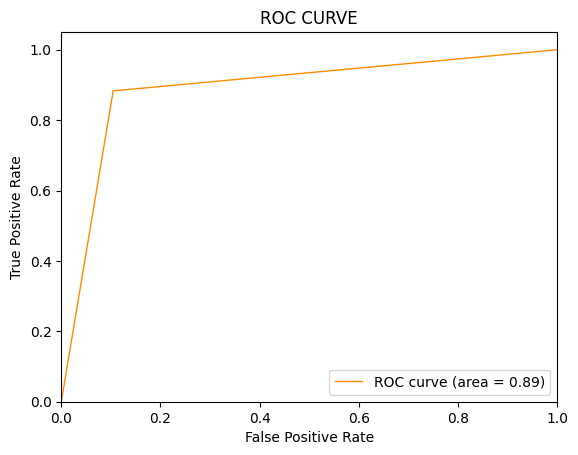

In [52]:
plot_roc_curve(val_labels, y_pred2)

## Model-3: LogisticRegression

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


              precision    recall  f1-score   support

           0       0.86      0.92      0.88      2486
           1       0.91      0.85      0.88      2514

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



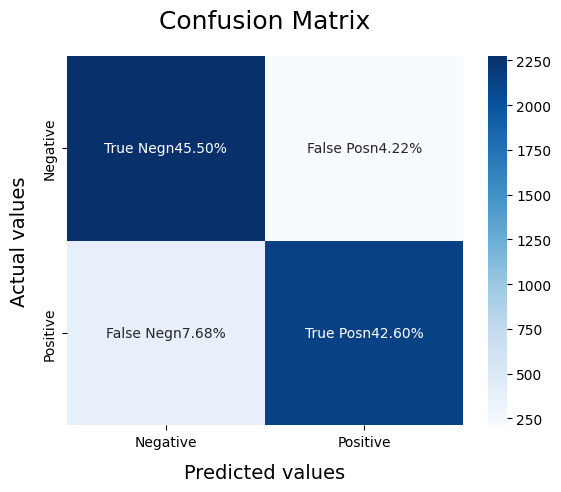

In [53]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(final_train_text, train_labels)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(final_val_text)

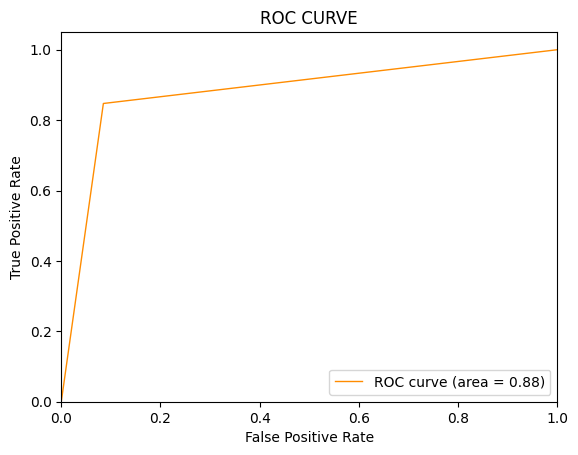

In [54]:
plot_roc_curve(val_labels, y_pred3)

# Predict Test_data

In [55]:
test_text = test_data['text']

In [56]:
test_text = test_text.apply(lambda text: cleaning_stopwords(text))
test_text.head()

0    I always wrote series complete stink-fest Jim ...
1    1st watched 12/7/2002 - 3 10(Dir-Steve Purcell...
2    This movie poorly written directed I fell asle...
3    The interesting thing Miryang (Secret Sunshine...
4    first read "berlin meer" expect much. thought ...
Name: text, dtype: object

In [57]:
test_text =  test_text.apply(lambda x: cleaning_punctuations(x))
test_text.tail()

4995    This kind picture John Lassiter would making t...
4996    A MUST SEE I saw WHIPPED press screening hilar...
4997    NBC ashamed I allow children see this I defini...
4998    This movie clumsy mishmash various ghoststory ...
4999    Formula movie illegitimate son rich Chilenian ...
Name: text, dtype: object

In [58]:
test_text = test_text.apply(lambda x: cleaning_repeating_char(x))
test_text.tail()

4995    This kind picture John Lassiter would making t...
4996    A MUST SEE I saw WHIPPED press screening hilar...
4997    NBC ashamed I allow children see this I defini...
4998    This movie clumsy mishmash various ghoststory ...
4999    Formula movie illegitimate son rich Chilenian ...
Name: text, dtype: object

In [59]:
test_text = test_text.apply(lambda x: cleaning_URLs(x))
test_text.tail()

4995    This kind picture John Lassiter would making t...
4996    A MUST SEE I saw WHIPPED press screening hilar...
4997    NBC ashamed I allow children see this I defini...
4998    This movie clumsy mishmash various ghoststory ...
4999    Formula movie illegitimate son rich Chilenian ...
Name: text, dtype: object

In [60]:
test_text = test_text.apply(lambda x: cleaning_numbers(x))
test_text.tail()

4995    This kind picture John Lassiter would making t...
4996    A MUST SEE I saw WHIPPED press screening hilar...
4997    NBC ashamed I allow children see this I defini...
4998    This movie clumsy mishmash various ghoststory ...
4999    Formula movie illegitimate son rich Chilenian ...
Name: text, dtype: object

In [61]:
for row in test_text:
    row=remove_html(row)

In [62]:
test_text = test_text.apply(tokenizer.tokenize)
test_text.head()

0    [i, always, wrote, series, complete, stinkfest...
1    [st, watched, dirsteve, purcell, typical, mary...
2    [this, movie, poorly, written, directed, i, fe...
3    [the, interesting, thing, miryang, secret, sun...
4    [first, read, berlin, meer, expect, much, thou...
Name: text, dtype: object

In [63]:
test_text = test_text.apply(lambda x: stemming_on_text(x))
test_text.head()

0    [i, always, wrote, series, complete, stinkfest...
1    [st, watched, dirsteve, purcell, typical, mary...
2    [this, movie, poorly, written, directed, i, fe...
3    [the, interesting, thing, miryang, secret, sun...
4    [first, read, berlin, meer, expect, much, thou...
Name: text, dtype: object

In [64]:
test_text = test_text.apply(lambda x: lemmatizer_on_text(x))
test_text.head()

0    [i, always, wrote, series, complete, stinkfest...
1    [st, watched, dirsteve, purcell, typical, mary...
2    [this, movie, poorly, written, directed, i, fe...
3    [the, interesting, thing, miryang, secret, sun...
4    [first, read, berlin, meer, expect, much, thou...
Name: text, dtype: object

In [65]:
test_text = [str (item) for item in test_text]

In [74]:
final_test_text = vectoriser.transform(test_text)

In [78]:
test_prediction = SVCmodel.predict(final_test_text)

In [79]:
test_prediction[:3]

array([0, 0, 0])

In [90]:
sample_sub = pd.read_csv('/kaggle/input/shai-training-2023-a-level-2/sample_submission.csv')

In [91]:
sample_sub.head()

,id,label
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN


In [92]:
sample_sub['label'] = test_prediction

In [93]:
sample_sub.head()

,id,label
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0


In [98]:
sample_sub.set_index('id', inplace=True)

In [99]:
sample_sub.to_csv('test_predict.csv')